In [1]:
import mlx.nn as nn
import mlx.core as mx
import math
from mlx.data import datasets
import mlx.optimizers as optim
from datasets_utils import cifar10
from mlx.utils import tree_flatten
import numpy as np

In [2]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(BasicBlock, self).__init__()
        self.bn = nn.BatchNorm(in_planes)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=3, padding=1, stride=1, bias=False)

    def __call__(self, x):
        out = self.conv(self.relu(self.bn(x)))
        return mx.concatenate([x, out], -1)

In [3]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_planes, growth_rate, block_class):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block_class, in_planes, growth_rate, num_layers)
    
    def _make_layer(self, block_class, in_planes, growth_rate, num_layers):
        layers = []
        for i in range(num_layers):
            layers.append(block_class(in_planes+i*growth_rate, growth_rate))
        return nn.Sequential(*layers)

    def __call__(self, x):
        return self.layer(x)

In [4]:
class TransitionLayer(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, stride=1, kernel_size=1)
        self.avgpool = nn.AvgPool2d(2)

    def __call__(self, x):
        return self.avgpool(self.conv(self.bn(x)))

In [5]:
class DenseNet(nn.Module):
    def __init__(self, depth, num_classes, growth_rate, reduction, width):
        super(DenseNet, self).__init__()
        in_planes = 2 * growth_rate
        dense_block_num_layers = int((depth - 4) / 2)
    
        self.conv1 = nn.Conv2d(3, in_planes, kernel_size=3, stride=1, padding=1, bias=False)

        self.block1 = DenseBlock(dense_block_num_layers, in_planes, growth_rate, BasicBlock)
        in_planes = int(in_planes + dense_block_num_layers * growth_rate)
        self.trans1 = TransitionLayer(in_planes, int(math.floor(in_planes * reduction))) # downsampling
        in_planes = int(math.floor(in_planes * reduction))
        self.block2 = DenseBlock(dense_block_num_layers, in_planes, growth_rate, BasicBlock)
        in_planes = int(in_planes + dense_block_num_layers * growth_rate)
        self.trans2 = TransitionLayer(in_planes, int(math.floor(in_planes * reduction))) # downsampling
        in_planes = int(math.floor(in_planes * reduction))
        self.block3 = DenseBlock(dense_block_num_layers, in_planes, growth_rate, BasicBlock)
        in_planes = int(in_planes + dense_block_num_layers * growth_rate)
        self.in_planes = in_planes

        self.bn1 = nn.BatchNorm(in_planes)
        self.relu1 = nn.ReLU()
        self.avg1 = nn.AvgPool2d(3) # downsampling
        self.fc1 = nn.Linear(in_planes * (width // 8), num_classes) # 8 = 2 ** N, N = downsampling steps taken across the network

    def __call__(self, x):
        out = self.conv1(x) 
        out = self.trans1(self.block1(out))
        out = self.trans2(self.block2(out))
        out = self.block3(out)
        out = self.relu1(self.bn1(out))
        out = self.avg1(out)
        # out = mx.mean(out, axis=[1, 2]).reshape(out.shape[0], -1)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        return out
        
        
        

In [6]:
model = DenseNet(30, num_classes=10, growth_rate=12, reduction=0.5, width=32)

In [7]:
mx.eval(model)
model

DenseNet(
  (conv1): Conv2d(3, 24, kernel_size=(3,), stride=(1, 1), padding=(1, 1), dilation=1, bias=False)
  (block1): DenseBlock(
    (layer): Sequential(
      (layers.0): BasicBlock(
        (bn): BatchNorm(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (conv): Conv2d(24, 12, kernel_size=(3,), stride=(1, 1), padding=(1, 1), dilation=1, bias=False)
      )
      (layers.1): BasicBlock(
        (bn): BatchNorm(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (conv): Conv2d(36, 12, kernel_size=(3,), stride=(1, 1), padding=(1, 1), dilation=1, bias=False)
      )
      (layers.2): BasicBlock(
        (bn): BatchNorm(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (conv): Conv2d(48, 12, kernel_size=(3,), stride=(1, 1), padding=(1, 1), dilation=1, bias=False)
      )
      (layers.3): BasicBlock(
        (bn): BatchNorm(60, eps=1e-05, mom

In [8]:
train_set = datasets.load_cifar10(train=True)
test_set = datasets.load_cifar10(train=False)

len(train_set), len(test_set)

(50000, 10000)

In [9]:
# def get_streamed_data(data, batch_size=0, shuffled=True):
#     def transform(x):
#         return x.astype("float32") / 255.0

#     buffer = data.shuffle() if shuffled else data
#     stream = buffer.to_stream()
#     stream = stream.key_transform("image", transform)
#     stream = stream.batch(batch_size) if batch_size > 0 else stream
#     return stream.prefetch(4, 2)

def get_streamed_data(data, batch_size=0, shuffled=True):
    mean = np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3))
    std = np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3))

    def normalize(x):
        x = x.astype("float32") / 255.0
        return (x - mean) / std

    buffer = data.shuffle() if shuffled else data
    stream = buffer.to_stream()
    stream = stream.image_random_h_flip("image", prob=0.5)
    stream = stream.pad("image", 0, 4, 4, 0.0)
    stream = stream.pad("image", 1, 4, 4, 0.0)
    stream = stream.image_random_crop("image", 32, 32)
    stream = stream.key_transform("image", normalize)
    stream = stream.batch(batch_size) if batch_size > 0 else stream
    return stream.prefetch(4, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

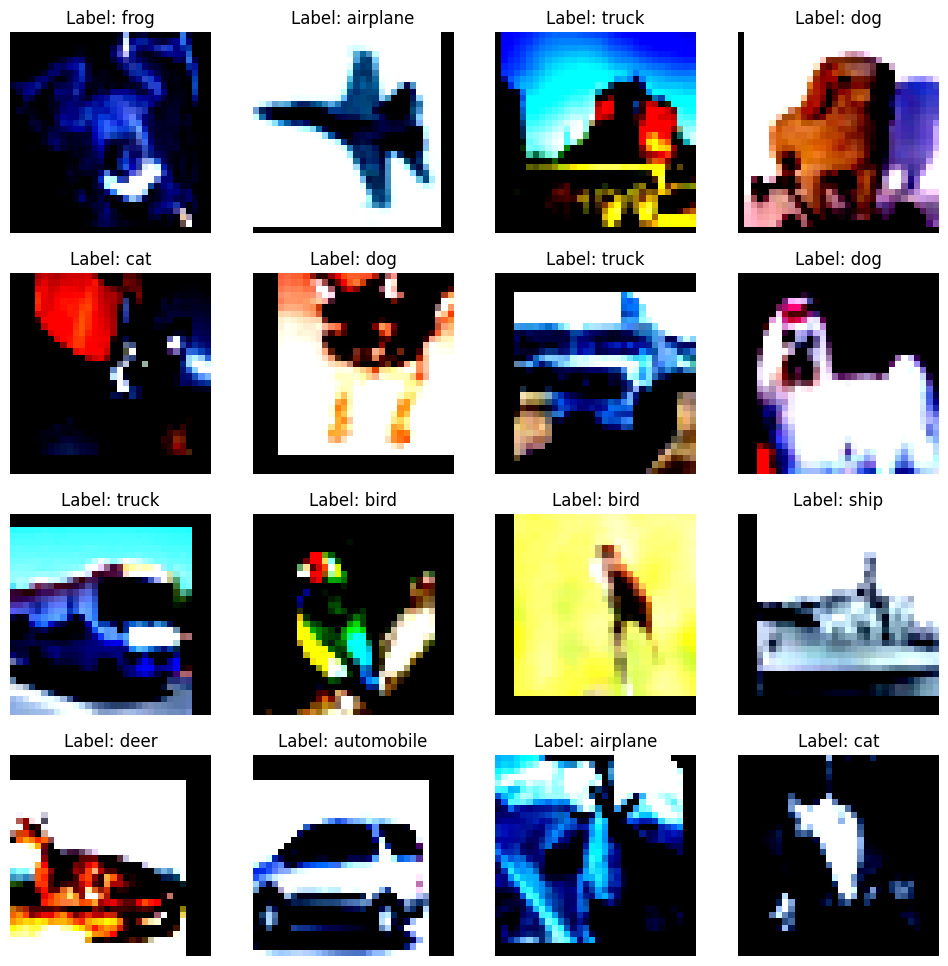

In [10]:
import matplotlib.pyplot as plt
mx.random.seed(42)

n_cols = 4
n_rows = 4
fig = plt.figure(figsize=(12, 12))
for i, batch in zip(range(n_cols * n_rows), get_streamed_data(train_set, batch_size=1)):    
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    img = mx.array(batch["image"])
    label = batch["label"].squeeze()
    label = cifar10.labels[label]
    img = img.astype(mx.float32)
    ax.set_title(f"Label: {label}")
    ax.set_axis_off()
    ax.imshow(img.squeeze())
plt.show()

In [11]:
d = next(get_streamed_data(batch_size=10, data=train_set, shuffled=False))
X, y = mx.array(d["image"]), mx.array(d["label"])

y_pred = model(X)
print(f"y_pred.shape -> {y_pred.shape}")
print(f"model.in_planes -> {model.in_planes}")

y_pred.shape -> (10, 10)
model.in_planes -> 279


In [12]:
import trainer

epochs = 50
optimizer = optim.SGD(learning_rate=0.005, weight_decay=0.0001, momentum=0.9, dampening=False)
# optimizer = optim.Adam(learning_rate=0.0005)
# optimizer = optim.Adam(learning_rate=0.0005)
batch_size = 64

train_data = get_streamed_data(batch_size=batch_size, data=train_set, shuffled=True)
test_data = get_streamed_data(batch_size=batch_size, data=test_set, shuffled=False)

train_accuracies = []
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    train_loss, train_acc, throughput = trainer.train_epoch(model, train_data, optimizer, epoch, verbose=False)
    print(" | ".join(
                (
                    f"Epoch: {epoch+1}",
                    f"avg. Train loss {train_loss.item():.3f}",
                    f"avg. Train acc {train_acc.item():.3f}",
                    f"Throughput: {throughput.item():.2f} images/sec",
                )))
    test_acc = trainer.test_epoch(model, test_data, epoch)
    print(f"Epoch: {epoch+1} | Test acc {test_acc.item():.3f}")

    train_accuracies.append(train_acc)
    train_losses.append(train_loss)
    test_accuracies.append(test_acc)

    train_data.reset()
    test_data.reset()

Epoch: 1 | avg. Train loss 2.071 | avg. Train acc 0.399 | Throughput: 351.77 images/sec
Epoch: 1 | Test acc 0.504
Epoch: 2 | avg. Train loss 1.911 | avg. Train acc 0.558 | Throughput: 351.89 images/sec
Epoch: 2 | Test acc 0.588
Epoch: 3 | avg. Train loss 1.854 | avg. Train acc 0.612 | Throughput: 351.22 images/sec
Epoch: 3 | Test acc 0.635
Epoch: 4 | avg. Train loss 1.809 | avg. Train acc 0.658 | Throughput: 339.18 images/sec
Epoch: 4 | Test acc 0.682
Epoch: 5 | avg. Train loss 1.780 | avg. Train acc 0.687 | Throughput: 341.95 images/sec
Epoch: 5 | Test acc 0.690
Epoch: 6 | avg. Train loss 1.753 | avg. Train acc 0.715 | Throughput: 350.62 images/sec
Epoch: 6 | Test acc 0.720
Epoch: 7 | avg. Train loss 1.732 | avg. Train acc 0.735 | Throughput: 351.43 images/sec
Epoch: 7 | Test acc 0.750
Epoch: 8 | avg. Train loss 1.713 | avg. Train acc 0.753 | Throughput: 351.66 images/sec
Epoch: 8 | Test acc 0.752
Epoch: 9 | avg. Train loss 1.699 | avg. Train acc 0.767 | Throughput: 351.73 images/sec


In [13]:
# get precision, recall, and f1-score
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

y_true = []
y_pred = []
model.eval()
for batch in test_data:
    X, y = batch["image"], batch["label"]
    X, y = mx.array(X), mx.array(y)
    logits = model(X)
    prediction = mx.argmax(mx.softmax(logits), axis=1)
    y_true = y_true + y.tolist()
    y_pred = y_pred + prediction.tolist()
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")
print(f"Precision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

test_data.reset()

Precision: 0.8705686470250629
Recall: 0.8705
F1 Score: 0.8696360972902967
